In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import json
import pickle

from ml_genn import InputLayer, Layer, SequentialNetwork, Network, Population, Connection
from ml_genn.callbacks import Checkpoint, SpikeRecorder, VarRecorder, Callback, OptimiserParamSchedule
from ml_genn.compilers import EventPropCompiler, InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.initializers import Normal
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput, LeakyIntegrateFireInput
from ml_genn.optimisers import Adam
from ml_genn.serialisers import Numpy
from ml_genn.synapses import Exponential
from time import perf_counter

from ml_genn.utils.data import (calc_latest_spike_time, linear_latency_encode_data)
from ml_genn.compilers.event_prop_compiler import default_params

from pygenn.genn_wrapper.CUDABackend import DeviceSelect_MANUAL

In [2]:
sample_id = 0

In [3]:
dir = "~/PhD/Intel-Neuromorphic-Research-Project/output/full_100_epoch/"

output = pd.read_csv(os.path.expanduser(dir + "train_output.csv"))

with open(os.path.expanduser(dir + "params.json"), "r") as f:
        params = json.load(f)

# change dir for readout files
# lazy fix until a solution can be implemented with ml_genn to support output file directory change
try:
    os.makedirs(params.get("output_dir") + params.get("sweeping_suffix"))
except:
    pass

os.chdir(params.get("output_dir") + params.get("sweeping_suffix"))

# Load dataset
x_train = np.load(os.path.expanduser(params.get("dataset_directory")) + "training_x_data.npy")
y_train = np.load(os.path.expanduser(params.get("dataset_directory")) + "training_y_data.npy")

x_test = np.load(os.path.expanduser(params.get("dataset_directory")) + "testing_x_data.npy")
y_test = np.load(os.path.expanduser(params.get("dataset_directory")) + "testing_y_data.npy")

# adding validation data if exists
validation_images = np.array([])
validation_labels = np.array([])
if os.path.isfile(os.path.expanduser(params.get("dataset_directory")) + "validation_y_data.npy"):
        print("!! validation dataset loaded successfully")
        x_validation = np.load(os.path.expanduser(params.get("dataset_directory")) + "validation_x_data.npy")
        y_validation = np.load(os.path.expanduser(params.get("dataset_directory")) + "validation_y_data.npy")

        validation_images = np.swapaxes(x_validation, 1, 2) 
        validation_images = validation_images + abs(np.floor(validation_images.min()))

        validation_labels = y_validation

#TODO: Redundant? any point to have a NUM_INPUT if data can be obtained through dataset shape
assert x_train.shape[1] == params.get("NUM_INPUT"), "dataset input size doesn't match passed input parameter size"

if params.get("NETWORK_SCALE") < 1:
    assert len(x_train) == len(y_train)
    p = np.random.permutation(len(x_train))
    x_train, y_train = x_train[p], y_train[p]
    print(f"original network size: {len(x_train)}")
    x_train = x_train[:int(len(x_train) * params.get("NETWORK_SCALE"))]
    y_train = y_train[:int(len(y_train) * params.get("NETWORK_SCALE"))]
    print(f"reduced network size: {len(x_train)}")
    print("!! network reduced")

if params.get("cross_validation"):
    training_details = pd.read_csv(os.path.expanduser(params.get("dataset_directory")) + "training_details.csv")
    testing_details = pd.read_csv(os.path.expanduser(params.get("dataset_directory")) + "testing_details.csv")

training_images = np.swapaxes(x_train, 1, 2) 
testing_images = np.swapaxes(x_test, 1, 2) 

training_images = training_images + abs(np.floor(training_images.min()))
testing_images = testing_images + abs(np.floor(testing_images.min()))

training_labels = y_train
testing_labels = y_test

serialiser = Numpy(os.path.expanduser(dir + "/SC"))
network = Network(default_params)
    
with network:
    # Populations
    input = Population(LeakyIntegrateFireInput(v_thresh=1, 
                                            tau_mem=20,    
                                            input_frames=params.get("NUM_FRAMES"), 
                                            input_frame_timesteps=params.get("INPUT_FRAME_TIMESTEP")),
                        params.get("NUM_INPUT"), 
                        record_spikes = True)
    
    hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                    tau_mem=20.0),
                params.get("NUM_HIDDEN"), 
                record_spikes=True)
    
    output = Population(LeakyIntegrate(tau_mem=20.0, 
                                readout="avg_var_exp_weight"),
                params.get("NUM_OUTPUT"), 
                record_spikes=True)

    Connection(input, hidden, Dense(Normal(mean = params.get("input_hidden_w_mean"), 
                                            sd = params.get("input_hidden_w_sd"))),
                Exponential(2.0))
    
    if params.get("recurrent"):
        Connection(hidden, hidden, Dense(Normal(mean = params.get("hidden_hidden_w_mean"), 
                                                sd = params.get("hidden_hidden_w_sd"))),
                Exponential(2.0))
    
    Connection(hidden, output, Dense(Normal(mean = params.get("hidden_output_w_mean"),
                                sd = params.get("hidden_output_w_sd"))),
                Exponential(2.0))

network.load((params.get("NUM_EPOCH") - 1,), serialiser)

compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                            reset_in_syn_between_batches=True,
                            #quantise_num_weight_bits=8,
                            #quantise_weight_percentile=99,
                            batch_size = params.get("BATCH_SIZE"))
compiled_net = compiler.compile(network)

with compiled_net:

    callbacks = [SpikeRecorder(input, 
                               key = "input_spikes",
                               example_filter = sample_id),
                 SpikeRecorder(hidden,
                               key = "hidden_spikes",
                               example_filter = sample_id),
                 VarRecorder(output, 
                             var = "v",
                             key = "output_voltages",
                             example_filter = sample_id)]

    metrics, cb_data = compiled_net.evaluate({input: testing_images * params.get("INPUT_SCALE")},
                                             {output: testing_labels},
                                             callbacks = callbacks)
    
    #compiled_net.save(("quant8",), serialiser)

    print(f"Accuracy = {100 * metrics[output].result}%")

!! validation dataset loaded successfully
swig/python detected a memory leak of type 'CodeGenerator::CUDA::Backend *', no destructor found.
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/full_100_epoch/InferenceCompiler_CODE'
make: Nothing to be done for 'all'.
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/full_100_epoch/InferenceCompiler_CODE'
Accuracy = 69.65924579736483%


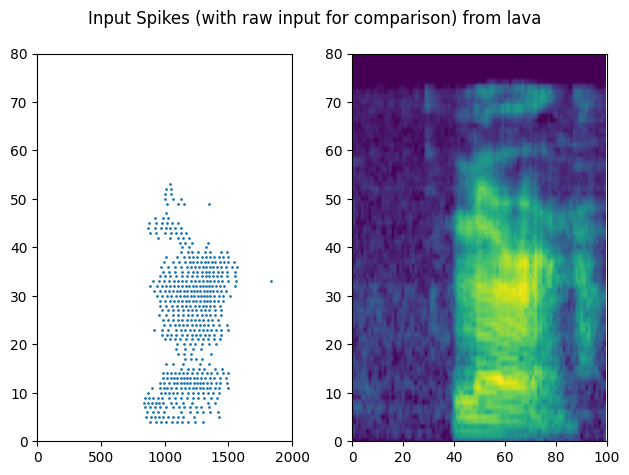

In [4]:
# Input spike activity
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Input Spikes (with raw input for comparison) from lava')

ax1.scatter(cb_data["input_spikes"][0][0], cb_data["input_spikes"][1][0],
            s = 1)

# no clue why I need to rotate and flip...could be investigated? 
ax2.imshow(np.flipud(np.rot90(testing_images[sample_id])), aspect = 'auto')

ax1.set_ylim(0, 80)
ax2.set_ylim(0, 80)
ax1.set_xlim(0, 2000)
ax2.set_xlim(0, 100)

fig.tight_layout()

plt.show()

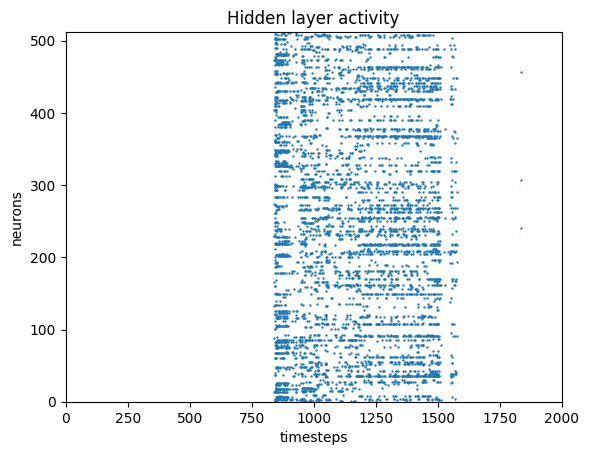

In [8]:
plt.scatter(cb_data["hidden_spikes"][0][0], cb_data["hidden_spikes"][1][0],
            s = 0.5)
plt.ylabel("neurons")
plt.xlabel("timesteps")
plt.title("Hidden layer activity")
plt.ylim(0, 512)
plt.xlim(0, 2000)
plt.show()

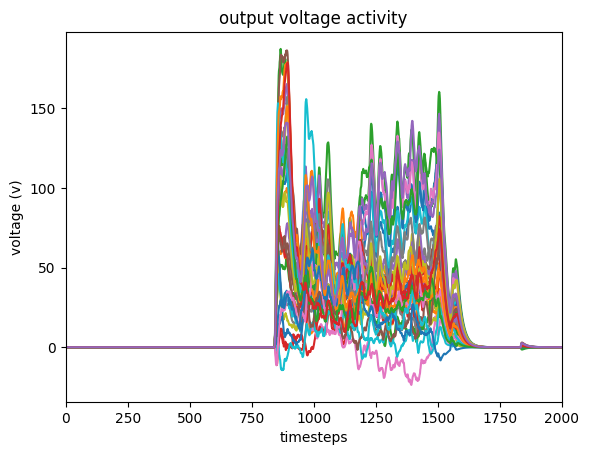

In [6]:
plt.plot(cb_data["output_voltages"][0])
plt.ylabel("voltage (v)")
plt.xlabel("timesteps")
plt.title("output voltage activity")
plt.xlim(0, 2000)
plt.show()